In [1]:
%pip install -r requirements.txt


[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import networkx as nx
import time
import random
import numpy as np
import pandas as pd
from random import randint
from multiprocessing.pool import Pool
from itertools import combinations
from psutil import Popen, TimeoutExpired
from networkx import Graph
from tempfile import NamedTemporaryFile

This is how to generate graphs:

In [3]:
def random_connected_graph(n_vertex: int, p_edge:float, seed:int = 42) -> Graph:
    """Generate a random connected graph.
    
    Args:
        n_vertex: No. of vertices in the generated graph.
        p_edge: Probability of generating a random edge between any two vertices.
        seed: Seed used to seed the random number generator.
    Returns:
        A random connected graph.
    """
    g = Graph()
    random.seed(seed)
    
    # generate a spanning tree that connects all vertices
    # this ensures that the resultant random graph would be connected
    unvisited = list(range(1, n_vertex))
    random.shuffle(unvisited)
    src = 0
    while len(unvisited) > 0:
        # pop a random unvisited vertex and connect them on the graph
        dest = unvisited.pop()
        g.add_edge(src, dest, weight=randint(1, n_vertex))
        src = dest
    
    # sample all combinations of edges between two vertices to create random edges on the graph
    for edge in combinations(range(n_vertex), 2):
        if random.random() < p_edge:
            g.add_edge(*edge, weight=randint(1, n_vertex))
    
    return g


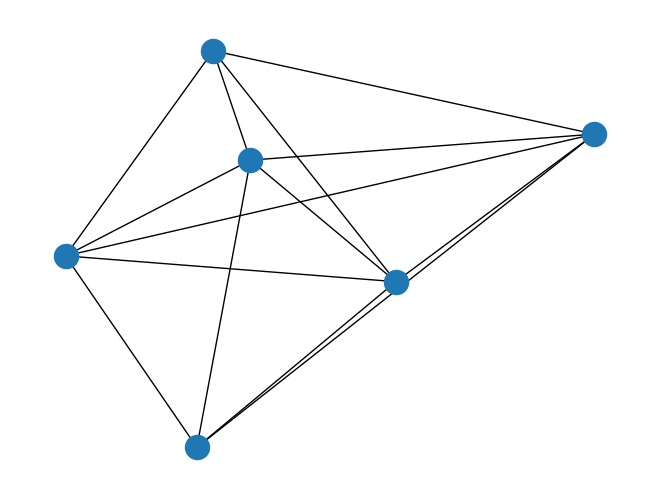

In [4]:
nx.draw(random_connected_graph(6,0.7777777777777777, 42))

How to run experiment trials:

In [5]:
def trial(graph: Graph, graph_adj: str, p_queue: str, start: int, end: int, program: str = "./a.out") -> dict[str, float]:
    """Perform one trial of djistrka shortest path.

    Args:
        graph: Weighted graph to perform shortest path on.
            Weights should be set on node data with the "weight" key
        graph_adj: Graph adjcency implementation to use. Either 'matrix' or 'list'.
        p_queue: Priority Queue implementation to use. Either 'array' or 'heap'.
        start: Starting node to traverse from.
        end: End node to traverse to.
        program: Path to the executable compiled from code.cpp.
        
    Returns: Dict of expriment statistics:
        - ram: no. of bytes consumed by the program
        - runtime: wall time elapsed by start and completion of the program.
    """
    with NamedTemporaryFile("w+") as f:
        # encode trial parameters into input file
        f.write(f"{graph.number_of_nodes()} {start} {end}\n")
        for src, dest, data in graph.edges(data=True):
            # simulate undirected edge via 2 directed edges in opposite directions
            f.write(f"{src} {data['weight']} {dest}\n")
            f.write(f"{dest} {data['weight']} {src}\n")
        f.flush()

        # run program as a subprocess
        begin = time.monotonic()
        process = Popen([program, graph_adj, p_queue, f.name])
        stats = {"ram": 0}
        while process.is_running():
            # record system resource usage
            stats["time"] = time.monotonic() - begin
            stats["ram"] = max(stats["ram"], process.memory_info().vms)
            try:
                process.wait(1e-6)
            except TimeoutExpired:
                pass
        return stats
        
    

In [17]:
def process(chunk):
    n_vertex, p_edge, graph_adj, pq = chunk
    graph = random_connected_graph(n_vertex, p_edge, seed=42)
    # run a shortest path trial from 0 -> random vertex
    stats = trial(graph, graph_adj, pq, 0, randint(0, n_vertex - 1))
    return stats | {
        "n_vertex": n_vertex,
        "p_edge": p_edge,
        "graph_adj": graph_adj,
        "priority_queue": pq,
    }


params = [
    (max(1, n_vertex), float(p_edge), graph_adj, pq)
    # 1, 50, ... 1000 vertices
    for n_vertex in range(0, 1000 + 1, 50)
    # p_edge = 0, 0.05, ... 1.0
    for p_edge in np.linspace(0, 1, 20)
    for graph_adj in ["matrix", "list"]
    for pq in ["array", "heap"]
]

random.shuffle(params)
df = pd.DataFrame(Pool().map(process, params))

In [18]:
df

,ram,time,n_vertex,p_edge,graph_adj,priority_queue
0,9175040,0.177792,550,0.315789,matrix,array
1,9912320,0.057977,700,0.210526,matrix,heap
2,45645824,0.286213,950,0.684211,list,heap
3,11202560,0.339603,950,0.052632,matrix,array
4,19165184,0.092360,650,0.526316,list,heap
...,...,...,...,...,...,...
1675,9850880,0.093669,550,0.315789,matrix,heap
1676,7180288,0.017698,600,0.000000,matrix,array
1677,6361088,0.018199,50,0.736842,list,heap
1678,9101312,0.164740,550,0.263158,matrix,array


In [23]:
df[(df["n_vertex"] == 1000) & (df["p_edge"] ==  1.0)]

,ram,time,n_vertex,p_edge,graph_adj,priority_queue
354,34803712,0.250898,1000,1.0,matrix,heap
800,62783488,0.382976,1000,1.0,list,heap
1339,60485632,0.946619,1000,1.0,list,array
1514,34803712,0.878818,1000,1.0,matrix,array


In [8]:
df.to_csv("results.csv")